In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns
import matplotlib.pyplot as plt
from util.pandas_util import pcap_to_df
sns.set(color_codes=True)
%matplotlib inline
pd.set_option('display.max_rows', None)

# Analyzing NDT Speedtest

**Objective:** In this section we will examine an [NDT speedtest](https://speed.measurementlab.net/#/) and empirically analyze the how it works.

In [3]:
pcap = rdpcap('pcaps/ndt_speed_test.pcap')

In [4]:
print(pcap)

<ndt_speed_test.pcap: TCP:41357 UDP:785 ICMP:2 Other:28>


### Writing Processed Output to Disk


In [3]:
# Stores the dataframe in memory
df = pcap_to_df('pcaps/ndt_speed_test.pcap')

# Writes the dataframe to disk
df.to_csv('csvs/ndt_speed_test.csv')

In [5]:
# Read PCAP from disk
df = pd.read_csv('csvs/ndt_speed_test.csv', index_col=0)

In [6]:
print(df.columns.values)

['version' 'ihl' 'tos' 'len' 'id' 'flags' 'frag' 'ttl' 'proto' 'chksum'
 'src' 'dst' 'options' 'time' 'tcp_sport' 'tcp_dport' 'tcp_seq' 'tcp_ack'
 'tcp_dataofs' 'tcp_reserved' 'tcp_flags' 'tcp_window' 'tcp_chksum'
 'tcp_urgptr' 'tcp_options' 'udp_sport' 'udp_dport' 'udp_len' 'udp_chksum']


### Understanding the Data

In [7]:
# Investigating hosts in dataset

src_hosts = df[['src']].rename(columns = {'src':'ip'})
dst_hosts = df[['dst']].rename(columns = {'dst':'ip'})

hosts = pd.concat([src_hosts, dst_hosts], axis=0).drop_duplicates()
hosts = hosts.reset_index(drop=True) # Resetting row number

hosts

,ip
0,192.168.0.203
1,192.168.0.221
2,192.168.0.1
3,170.114.52.3
4,142.250.68.74
5,142.250.68.42
6,142.250.189.10
7,104.22.14.220
8,142.251.2.113
9,74.125.137.188


We observe traffic on the 192.168.0.0/16 subnet. This is the subnet of the local network. We can label the direction of the traffic accordingly.

[Documentation for Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html)

In [8]:
# Labelling direction of traffic
df['is_inbound'] = np.where((df['dst'].str.split('.').str[0] == '192') & (df['dst'].str.split('.').str[1] == '168'), True, False)

In [9]:
inbound_traffic = df[df['is_inbound'] == True]

In [10]:
outbound_traffic = df[df['is_inbound'] == False]

### Viewing Flow Stats

In [11]:
df[['proto','src','dst','tcp_sport','tcp_dport', 'udp_sport', 'udp_dport']].drop_duplicates()

,proto,src,dst,tcp_sport,tcp_dport,udp_sport,udp_dport
0,6,192.168.0.203,192.168.3.118,53150.0,7000.0,NaN,NaN
1,17,192.168.0.221,255.255.255.255,NaN,NaN,49154.0,6667.0
2,17,192.168.0.1,192.168.0.255,NaN,NaN,46318.0,20002.0
3,6,192.168.0.203,142.250.68.74,53116.0,443.0,NaN,NaN
4,6,170.114.52.3,192.168.0.203,443.0,52780.0,NaN,NaN
5,6,170.114.52.3,192.168.0.203,443.0,52695.0,NaN,NaN
6,6,192.168.0.203,170.114.52.3,52780.0,443.0,NaN,NaN
7,6,192.168.0.203,170.114.52.3,52695.0,443.0,NaN,NaN
8,6,142.250.68.74,192.168.0.203,443.0,53116.0,NaN,NaN
9,6,170.114.52.3,192.168.0.203,443.0,52781.0,NaN,NaN


In [12]:
# Combine port number into a single column
df['sport'] = np.where(df['proto'] == 6, df['tcp_sport'],
                       np.where(df['proto'] == 17, df['udp_sport'], None))
df['dport'] = np.where(df['proto'] == 6, df['tcp_dport'],
                       np.where(df['proto'] == 17, df['udp_dport'], None))

In [13]:
inbound_traffic = df[df['is_inbound'] == True]
outbound_traffic = df[df['is_inbound'] == False]

In [12]:
inbound_traffic[['proto','src','dst','sport','dport']].drop_duplicates()

,proto,src,dst,sport,dport
0,6,192.168.0.203,192.168.3.118,53150.0,7000.0
2,17,192.168.0.1,192.168.0.255,46318.0,20002.0
4,6,170.114.52.3,192.168.0.203,443.0,52780.0
5,6,170.114.52.3,192.168.0.203,443.0,52695.0
8,6,142.250.68.74,192.168.0.203,443.0,53116.0
9,6,170.114.52.3,192.168.0.203,443.0,52781.0
17,6,142.250.68.42,192.168.0.203,443.0,53109.0
18,6,142.250.189.10,192.168.0.203,443.0,53118.0
19,6,104.22.14.220,192.168.0.203,443.0,53123.0
20,6,142.251.2.113,192.168.0.203,443.0,53119.0


In [100]:
inbound_traffic.groupby(['proto','src','dst','sport','dport'], dropna=False).agg({'len': 'sum'}).rename(columns = {'len':'total_bytes'}).sort_values('total_bytes', ascending=False)

total_bytes
proto src             dst           sport   dport               
6     4.15.166.11     192.168.0.203 443.0   53156.0     16763246
                                            53164.0       390834
      151.101.65.195  192.168.0.203 443.0   53151.0       328025
17    151.101.65.195  192.168.0.203 443.0   62021.0       106235
6     142.250.68.8    192.168.0.203 443.0   53154.0        93554
      142.250.176.14  192.168.0.203 443.0   53153.0        29616
17    142.250.176.14  192.168.0.203 443.0   64174.0        23941
      142.250.188.238 192.168.0.203 443.0   62629.0        15376
      142.250.189.14  192.168.0.203 443.0   57029.0        14920
      142.250.188.238 192.168.0.203 443.0   57262.0        12137
6     172.217.14.106  192.168.0.203 443.0   53162.0        11637
                                            53163.0        11637
17    142.250.68.78   192.168.0.203 443.0   50946.0        11143
6     142.250.68.78   192.168.0.203 443.0   53157.0         9921
17    172.217.14.106  192.168.0.203 443.0   62275.0         9851
      172.217.14.110  192.168.0.203 443.0   49682.0         9737
      172.217.14.106  192.168.0.203 443.0   52856.0         9614
6     142.250.68.78   192.168.0.203 443.0   53158.0         8381
      142.250.188.238 192.168.0.203 443.0   53160.0         8373
      142.250.189.14  192.168.0.203 443.0   53161.0         8369
      151.101.65.195  192.168.0.203 443.0   53152.0         8116
      172.217.14.110  192.168.0.203 443.0   53159.0         7914
      142.250.217.147 192.168.0.203 443.0   53155.0         7742
17    172.217.12.131  192.168.0.203 443.0   55412.0         7567
      142.250.68.78   192.168.0.203 443.0   61556.0         7295
      172.217.14.78   192.168.0.203 443.0   56129.0         7168
      142.250.176.14  192.168.0.203 443.0   49484.0         6981
      142.250.68.106  192.168.0.203 443.0   60945.0         4844
      142.250.68.46   192.168.0.203 443.0   61279.0         4505
6     192.168.0.203   192.168.0.166 52692.0 8009.0          1660
17    192.168.0.110   192.168.0.203 1900.0  58103.0         1400
6     192.168.0.166   192.168.0.203 8009.0  52692.0         1302
      142.250.72.174  192.168.0.203 443.0   53143.0          766
      13.226.225.6    192.168.0.203 443.0   53148.0          573
17    192.168.0.166   192.168.0.203 40598.0 58103.0          552
                                    49955.0 58103.0          552
                                    54684.0 58103.0          552
                                    55652.0 58103.0          552
6     192.168.0.203   192.168.3.118 53150.0 7000.0           384
      170.114.52.3    192.168.0.203 443.0   52781.0          364
                                            52780.0          364
                                            52695.0          364
      170.114.2.8     192.168.0.203 443.0   52690.0          363
1     192.168.0.1     192.168.0.203 NaN     NaN              354
17    192.168.0.1     192.168.0.255 40210.0 20002.0          354
                                    46318.0 20002.0          354
                      192.168.0.203 53.0    12609.0          289
                                            19135.0          183
                                            51732.0          163
                                            17195.0          162
      192.168.0.203   192.168.0.1   137.0   39879.0          149
                                            58499.0          149
      192.168.0.1     192.168.0.203 53.0    42412.0          139
                                            2370.0           139
                                            62079.0          138
                                            13447.0          138
                                            8015.0           132
                                            20839.0          127
                                            31011.0          127
                                            25995.0          121
                       

In [13]:
inbound_flow_stats = (
    inbound_traffic.groupby(['proto','src','dst'], dropna=False)
                   .agg({'len': 'sum',
                         'time': 'count'})
                   .rename(columns = {'time':'count'})
                   .rename(columns = {'len':'total_bytes'})
                   .sort_values('total_bytes', ascending=False)
)
inbound_flow_stats

total_bytes  count
proto src             dst                              
6     4.15.166.11     192.168.0.203     17154080  16519
      151.101.65.195  192.168.0.203       336141    255
17    151.101.65.195  192.168.0.203       106235     95
6     142.250.68.8    192.168.0.203        93554     74
17    142.250.176.14  192.168.0.203        30922     44
6     142.250.176.14  192.168.0.203        29616     34
17    142.250.188.238 192.168.0.203        27513     40
6     172.217.14.106  192.168.0.203        23274     24
17    172.217.14.106  192.168.0.203        19465     37
      142.250.68.78   192.168.0.203        18438     44
6     142.250.68.78   192.168.0.203        18302     33
17    142.250.189.14  192.168.0.203        14920     23
      172.217.14.110  192.168.0.203         9737     34
6     142.250.188.238 192.168.0.203         8373      9
      142.250.189.14  192.168.0.203         8369      9
      172.217.14.110  192.168.0.203         7914     10
      142.250.217.147 192.168.0.203         7742     19
17    172.217.12.131  192.168.0.203         7567     19
      172.217.14.78   192.168.0.203         7168      8
      142.250.68.106  192.168.0.203         4844     16
      142.250.68.46   192.168.0.203         4505     14
      192.168.0.1     192.168.0.203         3945     34
      192.168.0.203   192.168.0.1           2500     34
      192.168.0.166   192.168.0.203         2208      4
6     192.168.0.203   192.168.0.166         1660     15
17    192.168.0.110   192.168.0.203         1400      4
6     192.168.0.166   192.168.0.203         1302     10
      170.114.52.3    192.168.0.203         1092     21
      142.250.72.174  192.168.0.203          766     10
17    192.168.0.1     192.168.0.255          708      2
6     13.226.225.6    192.168.0.203          573      4
      192.168.0.203   192.168.3.118          384      6
      170.114.2.8     192.168.0.203          363      3
1     192.168.0.1     192.168.0.203          354      2
6     142.250.72.138  192.168.0.203          104      2
      104.22.14.220   192.168.0.203          104      2
      142.250.189.10  192.168.0.203          104      2
      142.250.68.42   192.168.0.203          104      2
      142.250.68.74   192.168.0.203          104      2
      34.36.124.104   192.168.0.203          104      2
      3.231.186.32    192.168.0.203          104      2
      172.217.12.142  192.168.0.203          104      2
      104.21.68.5     192.168.0.203          104      2
      74.125.137.188  192.168.0.203          104      2
      142.251.2.113   192.168.0.203          104      2
      170.114.14.69   192.168.0.203           83      1
      40.79.189.58    192.168.0.203           40      1

4.15.166.11 - level3  
151.101.65.195 - fastly  
142.250.68.8 - google  


In [14]:
outbound_flow_stats = (
    outbound_traffic.groupby(['proto','src','dst'], dropna=False)
                   .agg({'len': 'sum',
                         'time': 'count'})
                   .rename(columns = {'time':'count'})
                   .rename(columns = {'len':'total_bytes'})
                   .sort_values('total_bytes', ascending=False)
)
outbound_flow_stats

total_bytes  count
proto src           dst                                
6     192.168.0.203 4.15.166.11         28028630  23828
17    192.168.0.203 142.250.68.78          17266     45
                    172.217.14.106         16296     41
                    142.250.188.238        13201     33
                    142.250.176.14         10994     35
6     192.168.0.203 151.101.65.195         10925    145
17    192.168.0.203 151.101.65.195          9174     59
                    142.250.189.14          7053     18
                    142.250.68.46           6208     13
                    172.217.14.110          5732     33
6     192.168.0.203 142.250.68.8            4645     67
                    142.250.68.78           4452     38
17    192.168.0.203 172.217.12.131          4276     16
6     192.168.0.203 142.250.176.14          3576     38
17    192.168.0.203 142.250.68.106          2924     15
                    172.217.14.78           2870      5
6     192.168.0.203 172.217.14.106          2780     30
                    142.250.217.147         2228     20
                    142.250.188.238         1310     12
                    142.250.189.14          1277     12
                    172.217.14.110          1267     12
                    170.114.52.3            1092     21
                    142.250.72.174          1049     12
17    192.168.0.221 255.255.255.255          864      4
      192.168.0.203 239.255.255.250          816      4
      192.168.0.165 255.255.255.255          800      4
      192.168.0.1   224.0.0.251              576      8
6     192.168.0.203 170.114.2.8              415      3
                    13.226.225.6             401      5
                    104.21.68.5              180      3
                    142.250.72.138           144      3
                    142.250.189.10           144      3
                    142.250.68.42            144      3
                    142.250.68.74            144      3
                    34.36.124.104            144      3
                    142.251.2.113            144      3
                    172.217.12.142           144      3
                    104.22.14.220            144      3
                    3.231.186.32             144      3
                    170.114.14.69            139      2
                    74.125.137.188            92      2
                    52.112.86.198             52      1

In [117]:
# Unique packet lengths in data
df_stats = (
    df.groupby(['len'], dropna=False)
                   .agg({'time': 'count'})
                   .rename(columns = {'time':'count'})
                   .sort_values('len', ascending=False)
)
df_stats

,count
len,
1500,29650
1496,222
1492,1
1476,1
1452,118
1448,1
1393,1
1391,1
1389,1


### Zooming in on Interesting Flows

In [15]:
inbound_flow = inbound_traffic[(inbound_traffic['src'] == '4.15.166.11') & \
                                (inbound_traffic['dst'] == '192.168.0.203') & \
                                (inbound_traffic['proto'] == 6)]

In [16]:
# Window time by 1 second
inbound_flow['window'] = inbound_flow['time'].astype(int)

/tmp/ipykernel_1452621/2314501371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inbound_flow['window'] = inbound_flow['time'].astype(int)


In [21]:
inbound_flow_stats1 = (
    inbound_flow.groupby(['window'], dropna=False)
                   .agg({'len': 'sum',
                         'time': 'count'})
                   .rename(columns = {'time':'count'})
                   .rename(columns = {'len':'bytes'})
                   .sort_values('window', ascending=True)
)
inbound_flow_stats

,bytes,count
window,,
1697647440,237462,164
1697647441,1957616,1307
1697647442,1869116,1248
1697647443,1693500,1129
1697647444,1920000,1280
1697647445,1909500,1273
1697647446,2013000,1342
1697647447,1920000,1280
1697647448,1558500,1039


In [19]:
full_sized_inbound_flow = inbound_flow[inbound_flow['len'] == 1500]
full_sized_inbound_flow_stats = (
    full_sized_inbound_flow.groupby(['window'], dropna=False)
                   .agg({'len': 'sum',
                         'time': 'count'})
                   .rename(columns = {'time':'count'})
                   .rename(columns = {'len':'bytes'})
                   .sort_values('window', ascending=True)
)
full_sized_inbound_flow_stats

,bytes,count
window,,
1697647440,234000,156
1697647441,1956000,1304
1697647442,1869000,1246
1697647443,1693500,1129
1697647444,1920000,1280
1697647445,1909500,1273
1697647446,2013000,1342
1697647447,1920000,1280
1697647448,1558500,1039


Test is around 10 seconds long

In [22]:
# bytes/sec
inbound_flow_stats1[1:-1]['bytes'].mean()

890094.4210526316

In [23]:
# Mbits/sec
inbound_flow_stats1[1:-1]['bytes'].mean() * 8 / 1000000.0

7.120755368421053

In [25]:
inbound_flow_stats1['Mbits'] = inbound_flow_stats1['bytes'] * 8 / 1000000.0

<AxesSubplot:xlabel='window', ylabel='Mbits'>

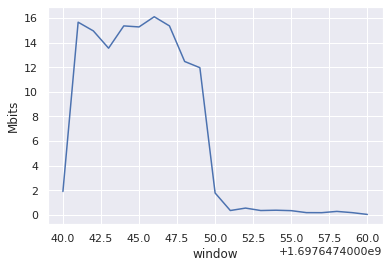

In [26]:
sns.lineplot(x = "window", y = "Mbits", 
             data = inbound_flow_stats1) 
  
